# Create SR images from downsampled HR images and display: Orig, HR, LR, SR

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


1 004_0005


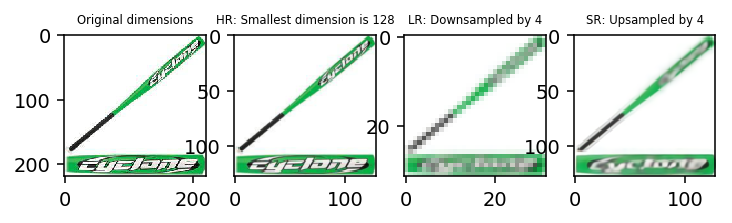

2 003_0005


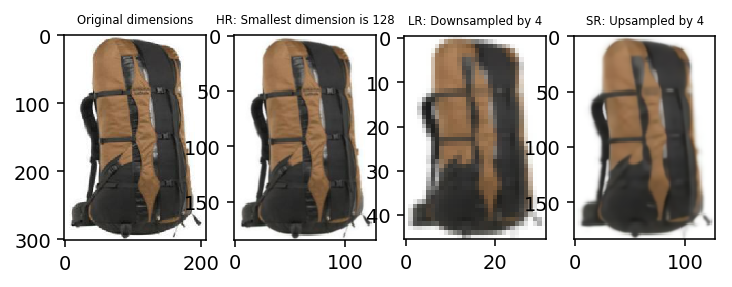

3 002_0003


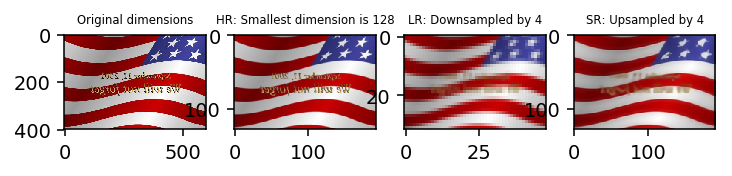

4 005_0005


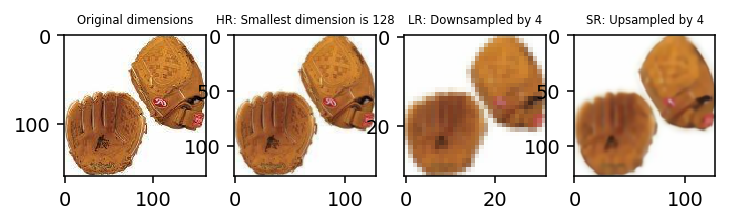

5 002_0002


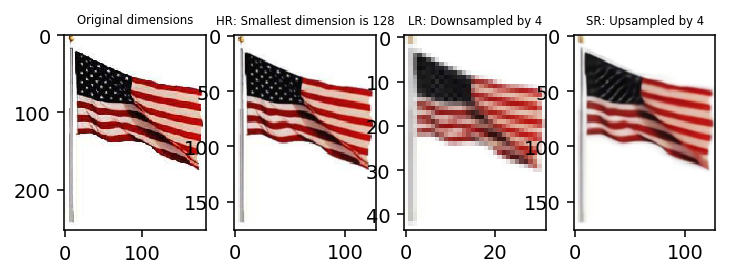

6 002_0005


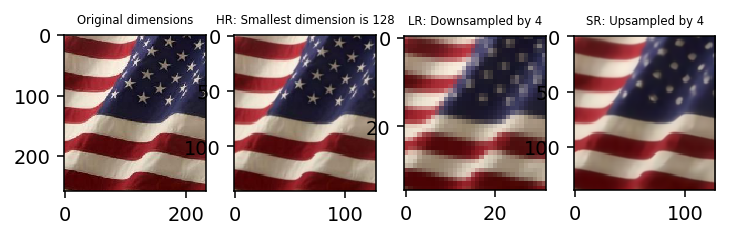

7 002_0001


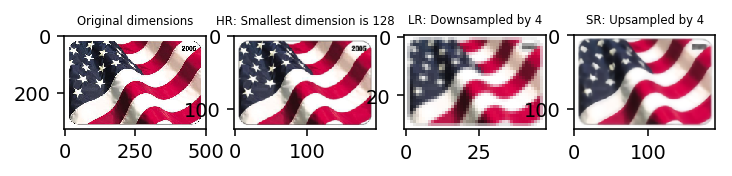

8 001_0005


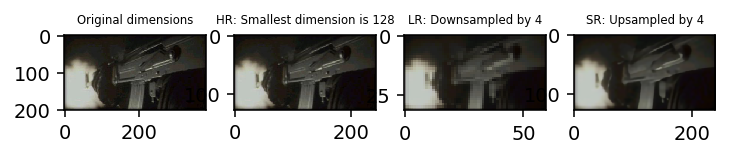

9 009_0005


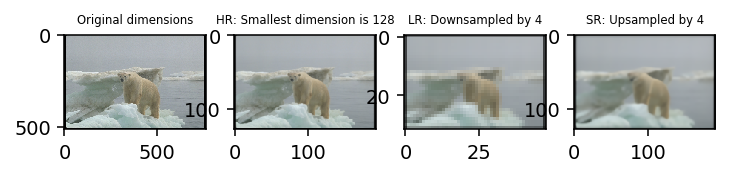

10 006_0005


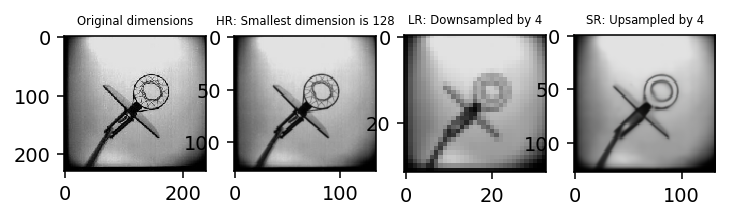

11 007_0005


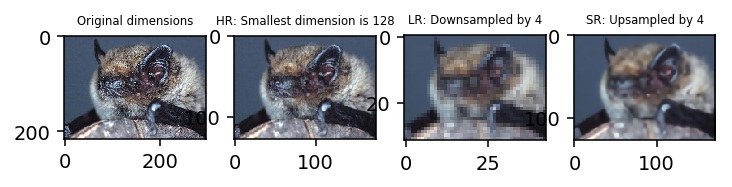

12 008_0005


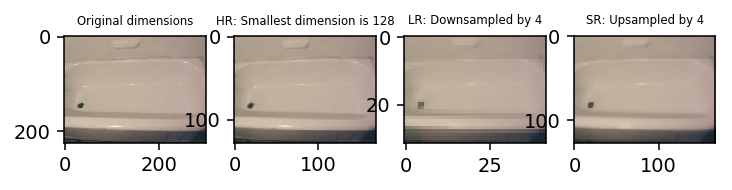

In [117]:
import os
import glob
import cv2
import numpy as np
import torch
import model 

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from util import calculate_psnr

import matplotlib.pyplot as plt


imageSize = 32
upSampling = 4
pretrained = 1 # Use generator network that was pretrained with trained ESRGAN network for psnr


if pretrained==1:
    model_path = 'SavedNetworks/Generator_pretrained_psnr.pth'
    netG = torch.load(model_path)
elif pretrained==0:
    model_path = 'SavedNetworks/Generator_from_scratch.pth'
    netG = torch.load(model_path)
else:
    model_path = 'SavedNetworks/RRDB_PSNR_x4.pth'  # the stored model
    netG = model.RRDB_Net(3, 3, 64, 23, gc=32, upscale=4, norm_type=None, act_type='leakyrelu', res_scale=1)
    netG.load_state_dict(torch.load(model_path), strict=True)

device = torch.device('cuda')  
#device = torch.device('cpu')

HR_img_folder = 'HR/*'


netG.eval()
for k, v in netG.named_parameters():
    v.requires_grad = False
netG = netG.to(device)

unnormalize = transforms.Normalize(mean = [-2.118, -2.036, -1.804], std = [4.367, 4.464, 4.444])

scale_LR = transforms.Compose([transforms.ToPILImage(),
                               transforms.Scale(imageSize),
                               transforms.ToTensor()#,
#                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                              ])

scale_HR = transforms.Compose([transforms.ToPILImage(),
                               transforms.Scale(imageSize*upSampling),
                               transforms.ToTensor()#,
#                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                              ])


idx = 0
path_HR = []
for path in glob.glob(HR_img_folder):
    path_HR.append(path)
    idx += 1
    base = os.path.splitext(os.path.basename(path))[0]
    print(idx, base)
    # read image
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    high_res = scale_HR(img[...,::-1])
    low_res = scale_LR(img[...,::-1])
    
    img = img * 1.0 / 255
    img = img[...,::-1]
    
    # original image
#     plt.imshow(img[...,::-1])
#     plt.show()
    img_orig = img
    
    
    # LR image
    to_pil = transforms.ToPILImage()
    hr_img = high_res.float().clamp_(0, 1).numpy()
    lr_img = low_res
#     display(lr_img)
    
    img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = lr_img.unsqueeze(0)
    img_LR = img_LR.to(device)

    output = netG(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
    output = (output * 255.0).round()
    
    hr_img = np.transpose(hr_img[[2, 1, 0], :, :], (1,2,0))
    lr_img = np.transpose(lr_img[[2, 1, 0], :, :].float().clamp_(0, 1).numpy(), (1,2,0))

    # store SR image
    cv2.imwrite('SR/{:s}_SR_{}.png'.format(base, pretrained), output)
    # store LR image
    cv2.imwrite('LR/{:s}_LR.png'.format(base), (lr_img * 255.0).round())
    
    img_SR = cv2.imread('SR/{:s}_SR_{}.png'.format(base, pretrained), cv2.IMREAD_COLOR)
    img_SR = img_SR * 1.0 / 255
    
    fs = 6
    plt.figure(dpi=140)
    plt.title('test')
    plt.subplot(141)
    plt.imshow(img_orig)
    plt.title('Original dimensions', fontsize=fs)
    plt.subplot(142)
    plt.imshow(hr_img[...,::-1])
    plt.title('HR: Smallest dimension is 128', fontsize=fs)
    plt.subplot(143)
    plt.imshow(lr_img[...,::-1])
    plt.title('LR: Downsampled by 4', fontsize=fs)
    plt.subplot(144)
    plt.imshow(img_SR[...,::-1])
    plt.title('SR: Upsampled by 4', fontsize=fs)
    plt.show()
 